In [49]:
%matplotlib inline

import numpy as np
import scipy

from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time

from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra, operators, adaptive
from pyiga import algebra_cy, ieti_cy

from scipy.sparse.linalg import aslinearoperator as LinOp

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)

In [50]:
def consistency_split(MP, a):
    patches_to_split = {}
    for (p1,b1) in MP.L_intfs:
        if len(MP.L_intfs[(p1,b1)])==2:
            p2 = MP.L_intfs[(p1,b1)][0][0]
            if a[MP.mesh.patch_domains[p1]] + 1e-3 < a[MP.mesh.patch_domains[p2]]:
                patches_to_split[p1]=None
    return patches_to_split

In [51]:
class IetiMapper:
    def __init__(self, M, dir_data, neu_data=None, elim=False):
        self.mesh = M
        self.numpatches = self.mesh.numpatches
        self.elim=bool(elim)
        self.Constr={}
        self.nConstr = 0

        self.P = {}
        self.intfs = set()
        self.L_intfs = {}

        #self.n = [tuple([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N = [np.prod([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        self.numdofs = self.N_ofs[-1]

        for ((p1,bd1,s1),((p2,bd2,s2),flip)) in self.mesh.interfaces.items():
            if ((p2,bd2,s2),(p1,bd1,s1),flip) not in self.intfs:
                self.intfs.add(((p1,bd1,s1),(p2,bd2,s2),flip))
            
        C=[self.computeInterfaceJump(p1, bspline._parse_bdspec(bd1,2), s1 , p2, bspline._parse_bdspec(bd1,2), s2, flip) for ((p1,bd1,s1),(p2,bd2,s2), flip) in self.intfs.copy()]
        if len(C)!=0:
            self.B = scipy.sparse.vstack(C)

        for (p,b,_),(p2,b2,_),flip in self.intfs:
            if (p,b) not in self.L_intfs:
                self.L_intfs[(p,b)]=[(p2,b2)]
            else:
                self.L_intfs[(p,b)].append((p2,b2))

        kvs = self.mesh.kvs
        geos = self.mesh.geos

        self.dir_idx = dict()
        self.dir_vals = dict()
        self.free = [np.arange(self.N[p]) for p in range(self.numpatches)]

        for key in dir_data:
            for p,b in self.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], b, dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(np.concatenate(self.dir_idx[p]), return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
            self.free[p] = np.setdiff1d(self.free[p],self.dir_idx[p],assume_unique=True)
            
        self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        self.global_free = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx, assume_unique=True)

        self.corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True)+self.N_ofs[p] for p, kvs in enumerate(self.mesh.kvs)])

        # if self.elim:
        #     p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.intfs], dtype=np.int32).T
        #     Basis = algebra_cy.pyx_compute_basis(B.shape[0], B.shape[1], B, maxiter=10)
        #     self.Basis, self.N_ofs, self.N, B = ieti_cy.pyx_compute_decoupled_coarse_basis(Basis.tocsc(), self.N_ofs.astype(np.int32), p_intfs)
        
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.numpatches)]
        nnz_per_col = self.B.getnnz(axis=0)
        # self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.skeleton = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.interior = np.setdiff1d(np.where(nnz_per_col == 0)[0], self.global_dir_idx)
        
        self.R_interior = self.numpatches*[None] ###TODO: without loops
        self.R_skeleton = self.numpatches*[None]
        self.R_interfaces = {}
        
        for p in range(self.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior,:][:,self.free[p]]
            for b in range(4):
                if not any([(p,b) in self.mesh.outer_boundaries[key] for key in self.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=b,ravel=True)
                    mask_intf[interface_dofs[1:-1]] = True
                    mask_skeleton[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                        mask_skeleton[self.dir_idx[p]]=False

                    self.R_interfaces[(p,b)] = Id[mask_intf,:][:,self.free[p]]
            self.R_skeleton[p] = Id[mask_skeleton,:][:,self.free[p]]

        # self.N -= np.array([len(self.dir_idx[p]) if p in self.dir_idx else 0 for p in range(self.numpatches)])
        # self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        # self.B = self.B[:,self.global_free]
        # self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.numpatches)]
        
    def assemble(self, a, f):
        if self.elim:
            A = [self.Basis.T @ assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) @ self.Basis for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [self.Basis.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        else:
            A = [assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        
        self.BCRestr = {p:assemble.RestrictedLinearSystem(A[p], RHS[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        RHS = [rhs if p not in self.dir_idx else self.BCRestr[p].b for p, rhs in enumerate(RHS)]
        A = [a if p not in self.dir_idx else self.BCRestr[p].A for p, a in enumerate(A)]

        return A, RHS

    def ConstraintMatrices(self, redundant = False):
        eliminated_constraints = np.repeat(False, self.B.shape[0])
        B = self.B.tocsc()
        if not redundant:
            eliminated_constraints = ieti_cy.eliminate_corner_constraints(B.indptr.astype(np.int32), B.indices.astype(np.int32), B.data, *B.shape, 
                                                                          self.corners.astype(np.int32), len(self.corners)).astype(bool)

        B = self.B[:,self.global_free]

        eliminated_constraints = eliminated_constraints | (B.getnnz(1)==0)
        B = B[~eliminated_constraints,:]
        ofs = np.cumsum([0]+[len(x) for x in self.free])
        return [B[:,ofs[p]:ofs[p+1]] for p in range(self.numpatches)], eliminated_constraints

    def parametersort(self, a):
        D = np.array([a[key] for key in self.mesh.patch_domains.values()], dtype=float)
        ieti_cy.pyx_parametersort(self.B.indptr, self.B.indices, self.B.data, *self.B.shape, np.repeat(D,self.N))

    def computeInterfaceJump(self, p1, bdspec1, s1, p2, bdspec2, s2, flip=None):
        """Join the dofs lying along boundary `bdspec1` of patch `p1` with
        those lying along boundary `bdspec2` of patch `p2`. 

        See :func:`compute_dirichlet_bc` for the format of the boundary
        specification.

        If `flip` is given, it should be a sequence of booleans indicating for
        each coordinate axis of the boundary if the coordinates of `p2` have to
        be flipped along that axis.
        """
        kvs1, kvs2 = self.mesh.patches[p1][0][0], self.mesh.patches[p2][0][0]
        if flip is None:
            flip=(self.sdim-1)*(False,)
        
        bkv1 = assemble.boundary_kv(kvs1, bdspec1)
        bkv2 = assemble.boundary_kv(kvs2, bdspec2, flip=flip) 
        
        #retrieve local dofs for each patch on the boundary
        dofs1 = assemble.boundary_dofs(self.mesh.patches[p1][0][0], bdspec1, ravel=True)
        dofs2 = assemble.boundary_dofs(self.mesh.patches[p2][0][0], bdspec2, ravel=True, flip=flip)
                
        #check for hierarchy of the boundary knot vectors. currently only supports knot vectors with equal degree.
        if all([kv1<=kv2 for kv1, kv2 in zip(bkv1,bkv2)]):
            pass
        elif all([kv2<=kv1 for kv1, kv2 in zip(bkv1,bkv2)]):      
            self.intfs.remove(((p1,2*bdspec1[0][0]+bdspec1[0][1],s1),(p2,2*bdspec2[0][0]+bdspec2[0][1],s2),flip))
            self.intfs.add(((p2,2*bdspec2[0][0]+bdspec2[0][1],s2),(p1,2*bdspec1[0][0]+bdspec1[0][1],s1),flip))
            p1, p2 = p2, p1
            bdspec1, bdspec2 = bdspec2, bdspec1
            bkv1, bkv2 = bkv2, bkv1
            dofs1, dofs2 = dofs2, dofs1
        else:
            #print(p1, bkv1, p2, bkv2)
            print('Interface coupling not possible between patch '+ str(p1) +' and patch '+str(p2)+'!')    

        self.Constr[(p1,p2)]=self.nConstr+np.arange(len(dofs2))
        self.nConstr+=len(dofs2)
            
        #Prolongation operator  
        P = scipy.sparse.coo_matrix(bspline.prolongation_tp(bkv1,bkv2))   #TODO: make parameter to generate prolongation matrix as coo_matrix directly?
        self.P[(p1,p2)] = (dofs1 + self.N_ofs[p1], dofs2 + self.N_ofs[p2], P) 
        
        #construct constraints for this interface
        data = np.concatenate([-P.data, np.ones(len(dofs2))])
        I = np.concatenate([P.row, np.arange(len(dofs2))])
        J = np.concatenate([dofs1[P.col] + self.N_ofs[p1],dofs2 + self.N_ofs[p2]])
        A = scipy.sparse.coo_matrix((data,(I,J)),(len(dofs2), self.N_ofs[-1])).tocsr()
        return A
        
    def nodes_as_primals(self, dir_boundary=False):  ###TODO: cythonize(?)
        """Get global vertices of the multipatch object as well as local nodal degrees of freedom corresponding to the vertices. 
        In case of T-junctions also obtain the $p$ global degrees of freedom and $p$ local degrees of freedom on the coarse patch.
        Additionally may include nodes on the Dirichlet boundary if desired."""
        deg = self.mesh.patches[0][0][0][0].p
        n = self.N_ofs[-1]
        loc_c = self.corners
        if not dir_boundary: loc_c = np.setdiff1d(loc_c, self.global_dir_idx, assume_unique=True) 
  
        idx = (self.B[:,loc_c].getnnz(1)>0) & (self.B.getnnz(1)==2)
        B = self.B[idx,:]
        #B = B[B.getnnz(1)==2,:]
        loc_c = np.unique(B.indices)
        if not dir_boundary: loc_c = np.setdiff1d(loc_c, self.global_dir_idx, assume_unique=True) 

        q = np.where(B.getnnz(0)>0)[0]
        R = scipy.sparse.coo_matrix((np.ones(len(q)),(np.arange(len(q)),q)),shape=(len(q),n)).tocsr()
        c_B = B@R.T
        c_B.eliminate_zeros()

        nodal_coeff = R.T@algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=10)
        #print(nodal_coeff)

        nodal_coeff += ieti_cy.identify_T_coefficients_from_corner_basis(nodal_coeff.indptr, nodal_coeff.indices, nodal_coeff.data, *nodal_coeff.shape,
                                                                         self.B.indptr,      self.B.indices,      self.B.data,       self.B.shape[0], deg)
        return nodal_coeff
        
    #def averages_as_primals(self):

    def completeDirichlet(self, U):
        return [self.BCRestr[p].complete(u) if p in self.BCRestr else u for p,u in enumerate(U)]

In [52]:
class PrimalSystem():
    def __init__(self, Prim):
        self.Prim = Prim
        self.nPrim = self.Prim.shape[1]

        self.Psi = scipy.sparse.csc_matrix((0,self.nPrim))
        self.A_prim = np.zeros(2*(self.nPrim,))
        self.RHS_prim = np.zeros(self.nPrim)
        self.R = []
        self.eliminate_pointwise = False

    def incorporate_PrimalConstraints(self, A, B, RHS, IMap, eliminate_pointwise=True):
        self.eliminate_pointwise = True
        self.nLagrangeMultipliers = B[0].shape[0]
        
        if self.nPrim == 0:
            return A, B, RHS
        K = len(A)
        self.C=[]
        
        for p in range(K):
            c = (self.Prim[IMap.N_ofs[p]:IMap.N_ofs[p+1],:].T).tocsr()
            c.eliminate_zeros()
            c = c[:,IMap.free[p]]
            jj = np.where((c.indptr[1:]-c.indptr[:-1])>0)[0]
            c = c[jj,:]
            self.C.append(c)
            self.R.append(scipy.sparse.coo_matrix((np.ones(c.shape[0]),(np.arange(c.shape[0]),jj)),(c.shape[0],self.nPrim)))
            
        self.nPrimConstr = [c.shape[0] for c in self.C]

        mod_A = [scipy.sparse.bmat([[A[p],self.C[p].T],[self.C[p], None]]) for p in range(K)]
        mod_RHS = [np.concatenate([RHS[p],np.zeros(self.nPrimConstr[p])]) for p in range(K)]

        mod_B = [scipy.sparse.hstack([B[p],scipy.sparse.csr_matrix((self.nLagrangeMultipliers, self.nPrimConstr[p]))]) for p in range(K)]
        return mod_A, mod_B, mod_RHS, self.C
        
    def compute_PrimalBasis(self, mod_A, mod_B, mod_RHS):
        #TODO: eliminate pointwise constraints if desired
        #if eliminate_pointwise:
            
        loc_solver=[solvers.make_solver(a, spd=True, symm=True) if self.nPrimConstr[i]==0 else solvers.make_solver(a, spd=False, symm=True) for i, a in enumerate(mod_A)]
        self.Psi = []
        Delta = []
        self.B_prim = np.zeros((self.nLagrangeMultipliers,self.nPrim))
        for p in range(len(mod_A)):
            RHS = scipy.sparse.vstack([scipy.sparse.csr_matrix((loc_solver[p].shape[0]-self.nPrimConstr[p],self.nPrimConstr[p])), scipy.sparse.identity(self.nPrimConstr[p])]).toarray()
            sol = loc_solver[p]@RHS
            psi, delta = sol[:(-self.nPrimConstr[p]),], sol[(-self.nPrimConstr[p]):,]
            #if psi.ndim==1: psi=psi[:,None]
            #if delta.ndim==1: delta=delta[:,None]
            Delta.append(delta)
            #print(self.C[p]@psi)
            self.Psi.append(psi@self.R[p])
            self.A_prim -= self.R[p].T@delta@self.R[p]
            self.B_prim += mod_B[p][:,:-self.nPrimConstr[p]]@self.Psi[-1]
            self.RHS_prim += self.Psi[-1].T@mod_RHS[p][:-self.nPrimConstr[p]]
        return loc_solver

    def distributePrimalSolution(self, u):
        u_prim = u[-1]
        return [u[p]+self.Psi[p]@u_prim for p in range(len(u)-1)]

    def PrimalSolution(self, u_prim):
        return [psi@u_prim for psi in self.Psi]

    # def sanity_check():
    #     assert scipy.spar
        

In [53]:
class IetiSystem():
    def __init__(self, A, B ,RHS, N, loc_solver = None, spd=False, symm=False):
        self.A = A
        self.B = B
        self.RHS = RHS
        self.N = N

        self.sanity_check()

        if loc_solver:
            assert len(loc_solver)==len(A), 'amount of local solvers does not match amount of local system matrices!'
            self.loc_solver=loc_solver
        else:
            self.loc_solver = [solvers.make_solver(a, spd=spd, symm=symm) for a in self.A]

        self.K = len(A)
        self.nLagrangeMultipliers = self.B[0].shape[0]

    def SaddlePointSystem(self, format='csr'):
        B = scipy.sparse.hstack(self.B)
        return scipy.sparse.bmat([[scipy.sparse.block_diag(self.A),B.T],[B,None]], format=format)

    def RHSforSaddlePointSystem(self):
        return np.concatenate(self.RHS+[np.zeros(self.nLagrangeMultipliers)])

    def SchurComplement(self, as_matrix=False):
        F = operators.SumOperator([LinOp(self.B[p])@self.loc_solver[p]@LinOp(self.B[p].T) for p in range(self.K)])
        if as_matrix:
            return F@np.identity(F.shape[1])
        return F

    def RHSforSchurComplement(self):
        return np.sum([self.B[p]@(self.loc_solver[p]@self.RHS[p]) for p in range(self.K)], axis=0)

    def constructSolutionFromLagrangeMultipliers(self, lam):
        return [(self.loc_solver[p]@(self.RHS[p]-self.B[p].T@lam))[:self.N[p]] for p in range(self.K)]
        
    def sanity_check(self):
        assert len(A)==len(B)==len(RHS), 'Length of input data incompatible!'
        K = len(A)
        assert np.all([B[0].shape[0]==B[p].shape[0] for p in range(K)]), 'Constraint matrices have incompatible number of constraints!'
        assert np.all([self.A[p].shape[0]==self.A[p].shape[1] for p in range(K)]), 'Local system matrices are not square!'
        assert np.all([self.B[p].shape[1] == self.A[p].shape[1] for p in range(K)]), 'Constraint matrices have incompatible dimension!'
        assert np.all([self.A[p].shape[0]==len(self.RHS[p]) for p in range(K)]), 'Local rhs vectors have incompatible dimension!'

In [54]:
class ScaledDirichletPreconditioner():
    def __init__(self, A ,B, IMap):
        self.A = A
        self.IMap = IMap
        self.K   = len(B)

        self.B = [B[p]@IMap.R_skeleton[p].T for p in range(self.K)]
        self.B_full   = scipy.sparse.hstack(self.B, format='csr')
        self.BN  = np.array([IMap.R_skeleton[p].shape[0] for p in range(self.K)]) 
        self.BN_ofs = np.cumsum(np.r_[0,self.BN])

        self.D = []
        self.S = [LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_skeleton[p].T) - 
                  LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_interior[p].T)
                  @solvers.make_solver(IMap.R_interior[p]@A[p]@IMap.R_interior[p].T, spd=True)
                  @LinOp(IMap.R_interior[p]@A[p].T@IMap.R_skeleton[p].T) for p in range(self.K)]

    def SchurMatrices(self): #for large number of degrees of freedom not feasible
        return [s@np.eye(s.shape[0]) for s in self.S]

    def setupMultiplicityScaling(self):
        d = ieti_cy.pyx_multiplicity_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
        self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 
        
    # def setupConstraintScaling(self):
    #     d = ieti_cy.pyx_constraint_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
    #     self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 

    def setupWeightScaling(self):
        d = ieti_cy.pyx_weight_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
        self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 
        
    def setupCoefficientScaling(self, a):  ###TODO: cythonize
        self.D = [scipy.sparse.csr_matrix((self.B[p].shape[1],self.B[p].shape[1])) for p in range(self.K)]
        for (p1,b1) in self.IMap.L_intfs:
            R1 = self.IMap.R_interfaces[(p1,b1)]@self.IMap.R_skeleton[p1].T
            for (p2,b2) in self.IMap.L_intfs[(p1,b1)]:
                R2 = self.IMap.R_interfaces[(p2,b2)]@self.IMap.R_skeleton[p2].T
                a1, a2 = a[self.IMap.mesh.patch_domains[p1]], a[self.IMap.mesh.patch_domains[p2]]
                self.D[p1] += (a2)/(a1+a2)*R1.T@scipy.sparse.identity(R1.shape[0])@R1
                self.D[p2] += (a1)/(a1+a2)*R2.T@scipy.sparse.identity(R2.shape[0])@R2
        
    def setupSelectionScaling(self):
        d = ieti_cy.pyx_selection_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
        self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 

    def setupDeluxeScaling(self):  ###TODO: cythonize and/or write it as solution of sparse systems (no computation of Schur matrices)
        self.D = [np.zeros((self.B[p].shape[1],self.B[p].shape[1])) for p in range(self.K)]
        S = self.SchurMatrices()
        for (p1,b1) in self.IMap.L_intfs:
            R1 = self.IMap.R_interfaces[(p1,b1)]@self.IMap.R_skeleton[p1].T
            S1 = R1@S[p1]@R1.T
            for (p2,b2) in self.IMap.L_intfs[(p1,b1)]:
                R2 = self.IMap.R_interfaces[(p2,b2)]@self.IMap.R_skeleton[p2].T
                S2 = R2@S[p2]@R2.T
                Inv = np.linalg.inv(S1+S2)
                self.D[p1]+=R1.T@(Inv@S2)@R1
                self.D[p2]+=R2.T@(Inv@S1)@R2
        
    def prec(self):
        assert len(self.D)==self.K, 'Not all scaling matrices given! Call a setup routine first!'
        self.BgD = [LinOp(self.B[p]@self.D[p]) for p in range(self.K)]
        B = scipy.sparse.hstack(self.B)
        print("Convergence condition: {:.3}".format(scipy.sparse.linalg.norm(B@scipy.sparse.block_diag(self.D).T@B.T@B-B))) #check Algebraic condition
        return operators.SumOperator([self.BgD[p]@self.S[p]@self.BgD[p].T for p in range(self.K)])     

setting up constraints took 0.01343679428100586 seconds.
Basis setup took 0.004398822784423828 seconds
Setting up Mapper took 0.02544093132019043 seconds.
Assembling took 0.044362545013427734 seconds.
Computing jump matrices took 0.0009062290191650391 seconds.
Setting up primal system took 0.0026950836181640625 seconds.
Setting up primal constraints took 0.004376888275146484 seconds.


ValueError: matmul: dimension mismatch with signature (n,k=0),(k=3,1?)->(n,1?)

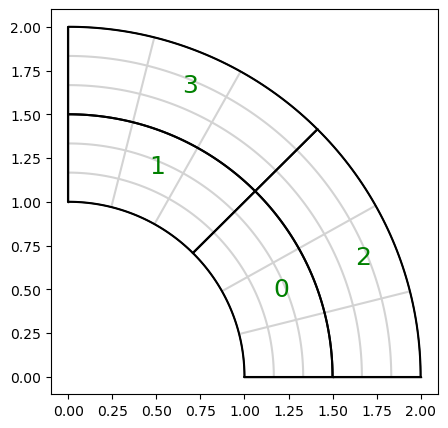

In [55]:
deg = 1
N = 3

knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
M.h_refine({0:0});
M.h_refine({0:1});
M.h_refine({1:1});
#M.h_refine();

#M.h_refine({1:1})
M.set_domain_id({1:{1}, 2:{2}})
#M.h_refine({0:-1});
#M.h_refine({2:1})

f={0:lambda x,y: 100., 1:lambda x,y: 100., 2:lambda x,y: 100.}
#idx=np.random.permutation(np.arange(4))
#idx=np.arange(4)
idx = [0,1,2]
values = [1,1e4, 1]

a = {idx[0]:values[0],idx[1]:values[1], idx[2]:values[2]}
#a = {0:1., 1:1e6, 2:1e4}
dir_data = {0:0}

MP = assemble.Multipatch(M, automatch=True)
marked_patches = {0}
# while len(marked_patches)>0:
#     marked_patches = consistency_split(MP,a)
#     print(marked_patches)
#     M.h_refine(patches=marked_patches,ref="rs");
#     MP = assemble.Multipatch(M, automatch=True)
#fig ,ax = plt.subplots(1, 2, figsize=(10, 5))
#M.plotmesh(knots=1, patch_idx=1, axis=ax[0])#, color={0:'yellow', 1:'blue', 2:'red', 3:'green'})
M.plotmesh(knots=1, patch_idx=1)
#plt.colorbar(label='Intensity')

t = time.time()
IMap = IetiMapper(M, dir_data)
IMap.parametersort(a)
print('Setting up Mapper took '+str(time.time()-t)+' seconds.')
t =time.time()
A, RHS = IMap.assemble(a,f)
print('Assembling took '+str(time.time()-t)+' seconds.')
N = [a.shape[0] for a in A]
t=time.time()
B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
print('Computing jump matrices took '+str(time.time()-t)+' seconds.')

SD = ScaledDirichletPreconditioner(A, B, IMap)

t=time.time()
primal = PrimalSystem(IMap.nodes_as_primals())
print('Setting up primal system took '+str(time.time()-t)+' seconds.')
t=time.time()
A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
print('Setting up primal constraints took '+str(time.time()-t)+' seconds.')
t=time.time()
loc_solver = primal.compute_PrimalBasis(A, B, RHS)
print('Setting up primal basis and local solvers took '+str(time.time()-t)+' seconds.')
A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), 
loc_solver.append(solvers.make_solver(primal.A_prim, symm=True, spd=True)), N.append(primal.A_prim.shape[0])

t=time.time()
I = IetiSystem(A, B, RHS, N, loc_solver)
F, b = I.SchurComplement(), I.RHSforSchurComplement()
print('Setting up Schur system took '+str(time.time()-t)+' seconds.')

F_mat = F@np.eye(F.shape[0])

P = EdgePreconditioner(IMap, SD.SchurMatrices(), SD.B, C)
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=1000, P=P, output=True, rtol=1e-6, atol=1e-12)

P = EdgePreconditionerFull(IMap, SD.SchurMatrices(), SD.B, C)
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=1000, P=P, output=True, rtol=1e-6, atol=1e-12)

# print('\n')

# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=1000, P=1, output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

# t=time.time()
# SD.setupMultiplicityScaling()
# print('Setting up multiplicity scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')


# t=time.time()
# SD.setupWeightScaling()
# print('Setting up weight scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

# t=time.time()
# SD.setupCoefficientScaling(a)
# print('Setting up coefficient scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

# t=time.time()
# SD.setupDeluxeScaling()
# print('Setting up deluxe scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

# t=time.time()
# SD.setupSelectionScaling()
# print('Setting up selection scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

# t=time.time()
# Prec = MsD_deluxe_whole(IMap, P.SchurMatrices(), P.B, C)
# print('Setting up edge scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=Prec, output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

# u_delta = I.constructSolutionFromLagrangeMultipliers(lam)[:-1]
# u_prim =primal.PrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam)[-1])

# u_delta = np.concatenate(IMap.completeDirichlet(u_delta))
# u_prim = np.concatenate(IMap.completeDirichlet(u_prim))

# # MP.plot(u_delta)
# # MP.plot(u_prim)
# #MP.plot(u_delta+u_prim, axis=ax[1])
# plt.axis('scaled');
# plt.show()

In [44]:
solvers.make_solver()

TypeError: make_solver() missing 1 required positional argument: 'B'

In [12]:
A=np.array([[[1,2],[3,4]],[[1,2],[3,4]]])

In [20]:
for i in range(A.shape[0]):
    print(A[i,:,:])

[[1 2]
 [3 4]]
[[1 2]
 [3 4]]


In [175]:
def EdgePreconditionerFull(IMap, S, B, C):
    S_ = [np.zeros(s.shape) for s in S]
    B_ = len(B)*[None]
    C_ = len(C)*[None]
    for p in range(IMap.numpatches):
        C_[p]=C[p]@IMap.R_skeleton[p].T
        B_[p] = scipy.sparse.hstack([B[p],scipy.sparse.csr_matrix((B[p].shape[0],C_[p].shape[0]))])
        for b in range(4):
            if (p,b) in IMap.R_interfaces:
                R = IMap.R_interfaces[(p,b)]@IMap.R_skeleton[p].T
                S_[p] += R.T@R@S[p]@R.T@R
        #print(S_[p].shape, C_[p].shape)
    return np.linalg.pinv(np.array([B_[p]@np.linalg.inv(scipy.sparse.block_array([[S_[p],C_[p].T],[C_[p],np.zeros(2*(C_[p].shape[0],))]]).toarray())@B_[p].T for p in range(len(S))]).sum(axis=0))

In [192]:
def EdgePreconditioner(IMap, S, B, C):
    m = B[0].shape[0]
    MsD = np.zeros((m,m))
    for (p1,b1) in IMap.L_intfs:
        R1 = IMap.R_interfaces[(p1,b1)]@IMap.R_skeleton[p1].T
        c = C[p1]@IMap.R_interfaces[(p1,b1)].T
        c = c[c.getnnz(1)>0,:].toarray()
        if c.shape[0]>0:
            S1_inv = np.linalg.inv(np.block([[R1@S[p1]@R1.T,c.T],[c, None]]))
        else:
            S1_inv = np.linalg.inv(R1@S[p1]@R1.T)
        S2_inv = []
        P = []
        B2 = []
        for (p2,b2) in IMap.L_intfs[(p1,b1)]:
            R2 = IMap.R_interfaces[(p2,b2)]@IMap.R_skeleton[p2].T
            S2_inv.append(np.linalg.inv(R2@S[p2]@R2.T))
            X = (B[p2]@R2.T)
            constr = np.where(X.getnnz(1)>0)[0]
            B2.append(B[p2]@R2.T)
            P.append(B[p1][constr,:]@R1.T)
        S2_inv = scipy.sparse.block_diag(S2_inv)
        P = scipy.sparse.vstack(P)
        B2 = scipy.sparse.hstack(B2)
        MsD+=B2@np.linalg.inv(S2_inv + P@S1_inv@P.T)@B2.T
    return MsD

In [193]:
M1 = EdgePreconditionerFull(IMap, SD.SchurMatrices(), SD.B, C)

In [194]:
M2 = EdgePreconditioner(IMap, SD.SchurMatrices(), SD.B, C)

In [195]:
M1

array([[ 1.57336, -0.53977,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [-0.53977,  1.69241,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.97464, -0.3879 ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     , -0.3879 ,  1.04112,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  1.20547, -0.09136,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     , -0.09136,  1.19743,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.58143, -0.05962],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.05962,  0.5831 ]])

In [196]:
M2

array([[ 1.57336, -0.53977,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [-0.53977,  1.69241,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.97464, -0.3879 ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     , -0.3879 ,  1.04112,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  1.20547, -0.09136,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     , -0.09136,  1.19743,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.58143, -0.05962],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.05962,  0.5831 ]])

In [183]:
print(M2@F_mat)

[[ 5.94959e-01  3.61698e-01  4.40230e-25  7.33716e-26  1.87214e-05  3.33051e-06 -3.33060e-02 -1.87216e-01]
 [ 3.51635e-01  5.46737e-01  6.23799e-25  1.03966e-25  2.12234e-05  2.75115e-06 -2.75128e-02 -2.12236e-01]
 [ 4.55398e-25  1.04672e-24  1.75446e+00  1.10978e+00  2.57545e-01 -2.67957e-03  2.67957e-03 -2.57545e-01]
 [ 2.26652e-25  5.20952e-25  1.12555e+00  1.52193e+00  1.99495e-01  2.30994e-03 -2.30994e-03 -1.99495e-01]
 [ 1.52577e-05  2.17201e-05  1.44650e-01  9.01620e-02  7.42602e-01  1.06134e-01  4.47905e-07  9.96066e-07]
 [ 4.30006e-06  4.04423e-06  8.10675e-03  9.75533e-03  1.09361e-01  7.09640e-01  2.29078e-07  5.09432e-07]
 [-9.72601e-02 -9.55627e-02 -2.47620e-02 -2.51449e-02  1.10723e-06  4.97893e-07  3.05896e+00  6.66734e-01]
 [-3.18640e-01 -4.52472e-01 -3.00305e-01 -1.87439e-01  2.09262e-06  9.41002e-07  6.39917e-01  3.30259e+00]]


In [159]:
big_array = np.array([1, 2, 3, 4, 5])
small_array = np.array([2, 4])

indices = np.where(np.isin(big_array, small_array))[0]
print(indices)  # O

[1 3]


# Checkerboard mesh with jumping coefficients (larger coefficient has coarser grid)

setting up constraints took 0.051210880279541016 seconds.
Basis setup took 0.004891157150268555 seconds
deg = 1
Iteration 0


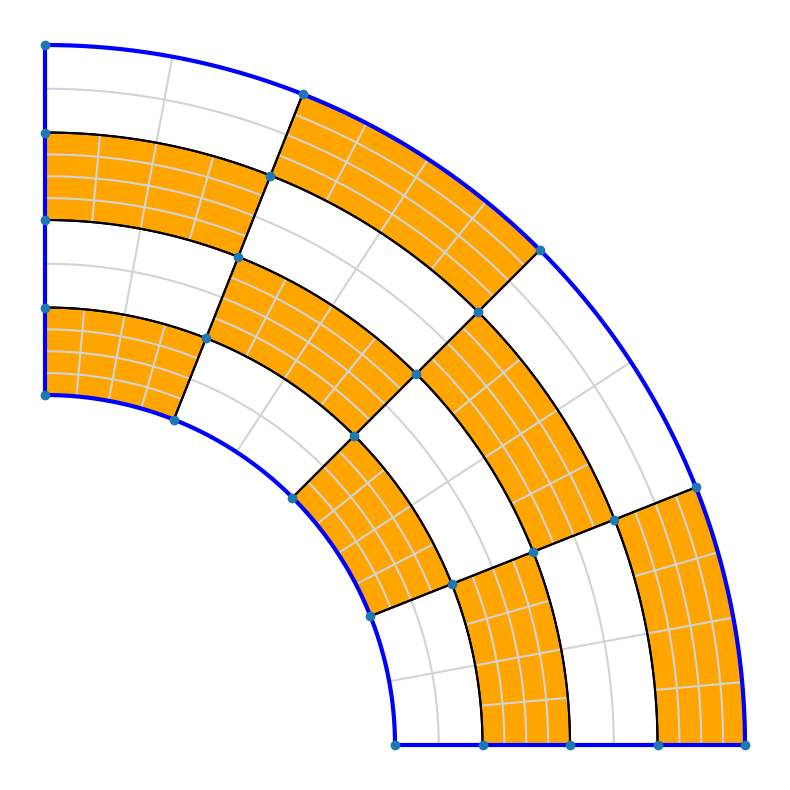

setting up constraints took 0.03163027763366699 seconds.
Basis setup took 0.0024290084838867188 seconds
Setting up IETI-mapper took 0.0759 seconds.
Assembling the system took 0.151 seconds.
Computing jump matrices took 0.00133 seconds.
Setting up primal system took 0.00173 seconds.
Setting up primal constraints took 0.0135 seconds.
Computing primal basis took 0.0195 seconds.
Setting up Schur complements took 0.00368 seconds.
Setting up selection scaling took 0.00345 seconds.
Convergence condition: 6.93
pcg with preconditioned condition number κ ~ 1.257e+03 stopped after 28 iterations with relres 4.732e-07 after 0.0714 seconds.
pcg with preconditioned condition number κ ~ 4.215 stopped after 11 iterations with relres 2.738e-07 after 0.0201 seconds.
Computing full solution from skeleton took 0.00441 seconds.
Full time for the IETI-solver: 0.0462 seconds
#####################################################
Iteration 1


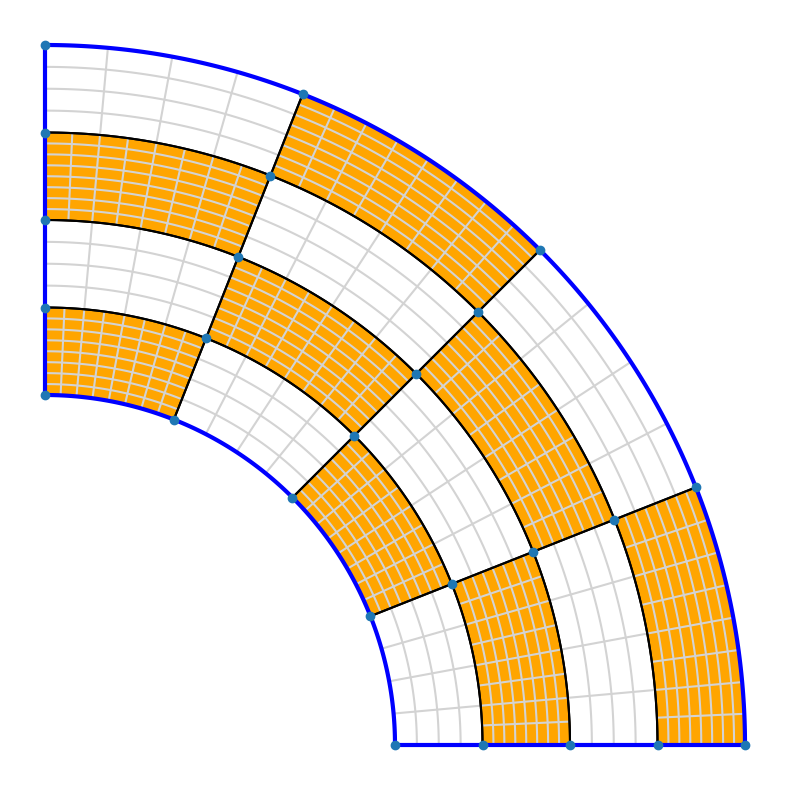

setting up constraints took 0.03268265724182129 seconds.
Basis setup took 0.0023512840270996094 seconds
Setting up IETI-mapper took 0.0736 seconds.
Assembling the system took 0.124 seconds.
Computing jump matrices took 0.00104 seconds.
Setting up primal system took 0.00169 seconds.
Setting up primal constraints took 0.0144 seconds.
Computing primal basis took 0.0218 seconds.
Setting up Schur complements took 0.00221 seconds.
Setting up selection scaling took 0.00296 seconds.
Convergence condition: 12.0
pcg with preconditioned condition number κ ~ 4.324e+03 stopped after 55 iterations with relres 8.452e-07 after 0.138 seconds.
pcg with preconditioned condition number κ ~ 5.984 stopped after 12 iterations with relres 7.637e-07 after 0.0198 seconds.
Computing full solution from skeleton took 0.00329 seconds.
Full time for the IETI-solver: 0.0463 seconds
#####################################################
Iteration 2


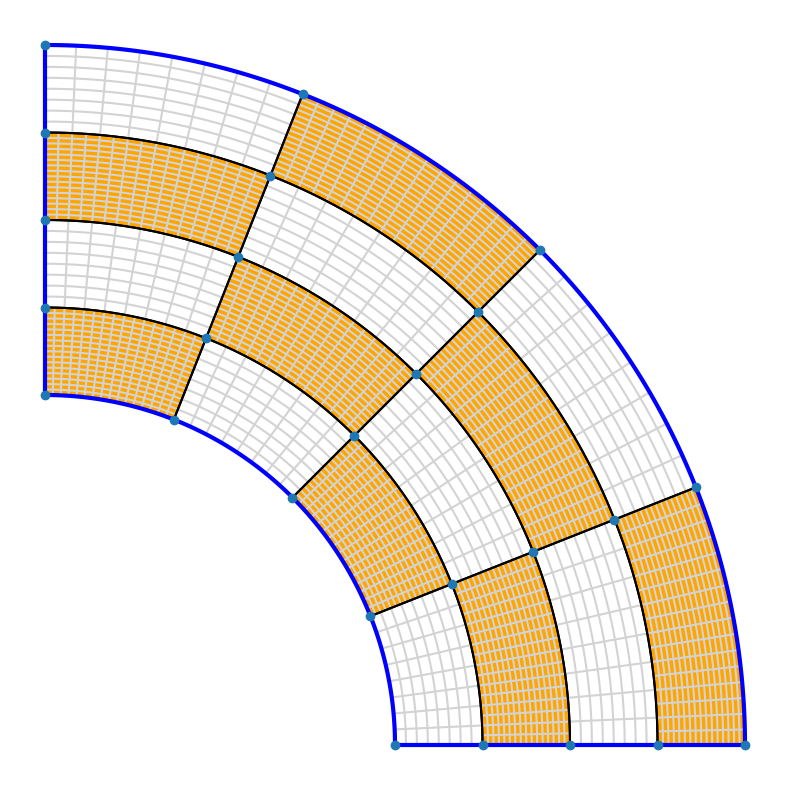

setting up constraints took 0.036971330642700195 seconds.
Basis setup took 0.0025031566619873047 seconds
Setting up IETI-mapper took 0.0757 seconds.
Assembling the system took 0.176 seconds.
Computing jump matrices took 0.00122 seconds.
Setting up primal system took 0.00185 seconds.
Setting up primal constraints took 0.0141 seconds.
Computing primal basis took 0.0239 seconds.
Setting up Schur complements took 0.00245 seconds.
Setting up selection scaling took 0.003 seconds.
Convergence condition: 18.3
pcg with preconditioned condition number κ ~ 1.215e+04 stopped after 106 iterations with relres 4.916e-07 after 0.326 seconds.
pcg with preconditioned condition number κ ~ 8.531 stopped after 14 iterations with relres 5.572e-07 after 0.0304 seconds.
Computing full solution from skeleton took 0.00339 seconds.
Full time for the IETI-solver: 0.0487 seconds
#####################################################


In [33]:
#degs = (2,3,4,5,6,7,8)
#maxiters=(6,6,6,5,5,4,4) ##<8

degs=(1,)
maxiters=(3,)
R1 = np.zeros((max(maxiters),2*len(degs)))
R2 = np.zeros((max(maxiters),2*len(degs)))

f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1000.,1:1.}
dir_data = {0:0}

plot=True

for i, deg in enumerate(degs):
    N = deg+1
    knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
    M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
    M.h_refine()
    M.h_refine()
    M.set_domain_id({1:{0,1,2,3,6,9,12,15}})
    #M.h_refine({p:-1 for p in {0,1,2,3,6,9,12,15}})
    M.h_refine({p:-1 for p in {4,5,7,8,10,11,13,14}})

    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiters[i]):
        print("Iteration {}".format(k))
        if plot:
            M.plotmesh(figsize=(10,10),color={1:'white',0:'orange'}, knots=1, bwidth=3, nodes=1, bcolor={0:'blue'})
            plt.axis('off');
            plt.axis('scaled');
            plt.savefig('/home/wolfman/Pictures/IETI-checkerboard/i'+str(k)+'.pdf',bbox_inches='tight')
            plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        t_IETI = 0
        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(a)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=a,f=f)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]

        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=True)
        I = IetiSystem(A, B, RHS, N)

        # A_full = I.SaddlePointSystem(format='csc')
        # RHS_full = I.RHSforSaddlePointSystem()
        # eps=1e-6

        # z = np.zeros(A_full.shape[0])
        # z[-B[0].shape[0]:]=eps
        # A_full += scipy.sparse.spdiags(z,0,*A_full.shape)
    
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        t=time.time()

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        t_IETI+=time.time()-t
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        t_IETI+=time.time()-t
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        t_IETI+=time.time()-t
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        t_IETI+=time.time()-t
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        SD.setupSelectionScaling()
        t_IETI+=time.time()-t
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)

        #t=time.time()
        #U = solvers.make_solver(A_full, symm=True)@RHS_full
        #print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R1[k,2*i] = it
        R1[k,2*i+1] = abs(max_eig/min_eig)

        P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P, output=True, rtol=1e-6, atol=1e-12)
        R2[k,2*i] = it
        R2[k,2*i+1] = abs(max_eig/min_eig)
        
        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        t=time.time()
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        t_IETI+=time.time()-t
        print("Computing full solution from skeleton took {:.3} seconds.".format(time.time()-t))
        print("Full time for the IETI-solver: {:.3} seconds".format(t_IETI))
        #print(len(u))
        #MP.plot(u)

        #err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        #marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        #marked_patches = {p:None for p in marked_patches}

        M.h_refine(-1);
        print("#####################################################")
#np.savetxt('checkerboard_badselection.txt', R1, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')
#np.savetxt('checkerboard_badedge.txt', R2, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')

# Checkerboard mesh with changing disparity level

setting up constraints took 0.03920102119445801 seconds.
Basis setup took 0.002452373504638672 seconds
deg = 1
Iteration 0


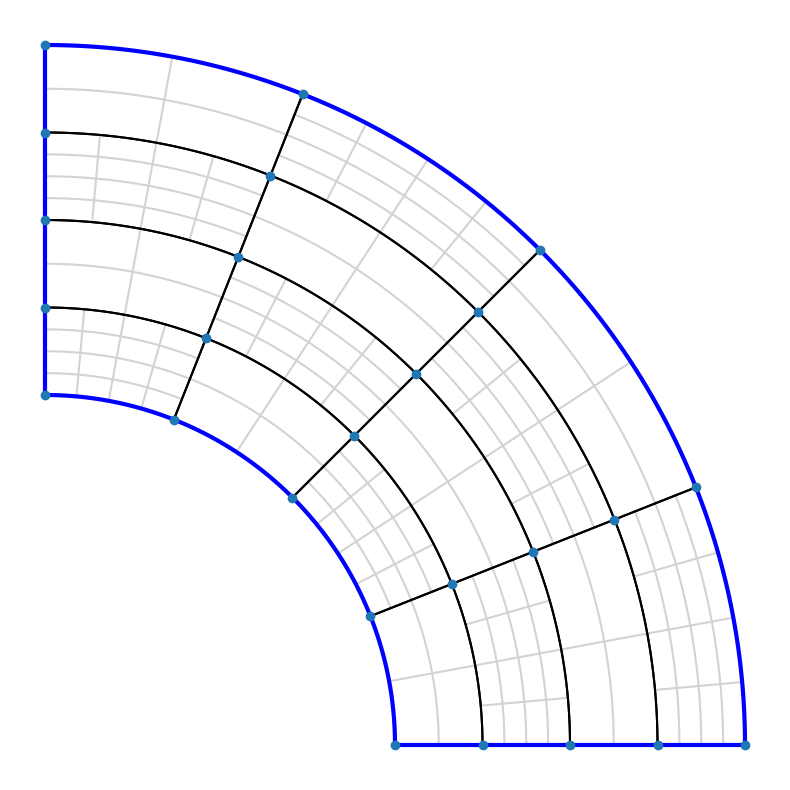

setting up constraints took 0.03192257881164551 seconds.
Basis setup took 0.002461671829223633 seconds
Setting up IETI-mapper took 0.0806 seconds.
Assembling the system took 0.162 seconds.
Computing jump matrices took 0.000993 seconds.
Setting up primal system took 0.00223 seconds.
Setting up primal constraints took 0.0139 seconds.
Computing primal basis took 0.0256 seconds.
Setting up Schur complements took 0.00231 seconds.
Setting up selection scaling took 0.00304 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 4.751 stopped after 11 iterations with relres 2.82e-07 after 0.0301 seconds.
pcg with preconditioned condition number κ ~ 4.161 stopped after 12 iterations with relres 3.445e-07 after 0.0311 seconds.
Computing full solution from skeleton took 0.00798 seconds.
Full time for the IETI-solver: 0.055 seconds
#####################################################
Iteration 1


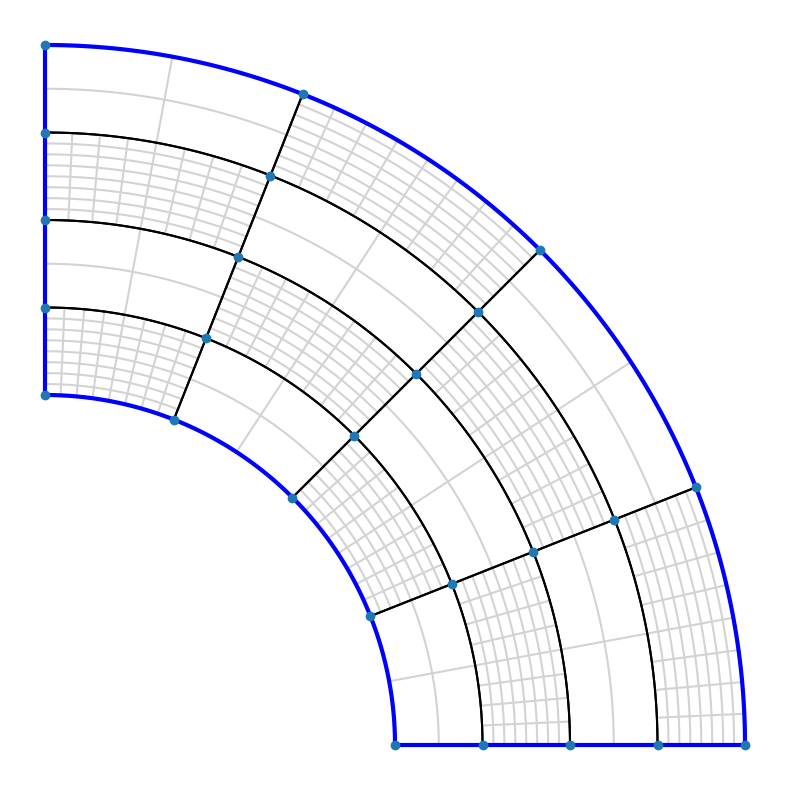

setting up constraints took 0.03147172927856445 seconds.
Basis setup took 0.0024449825286865234 seconds
Setting up IETI-mapper took 0.0714 seconds.
Assembling the system took 0.124 seconds.
Computing jump matrices took 0.00103 seconds.
Setting up primal system took 0.00185 seconds.
Setting up primal constraints took 0.0132 seconds.
Computing primal basis took 0.0212 seconds.
Setting up Schur complements took 0.00231 seconds.
Setting up selection scaling took 0.00292 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 4.826 stopped after 11 iterations with relres 3.561e-07 after 0.0313 seconds.
pcg with preconditioned condition number κ ~ 6.017 stopped after 14 iterations with relres 5.017e-07 after 0.0218 seconds.
Computing full solution from skeleton took 0.00283 seconds.
Full time for the IETI-solver: 0.0442 seconds
#####################################################
Iteration 2


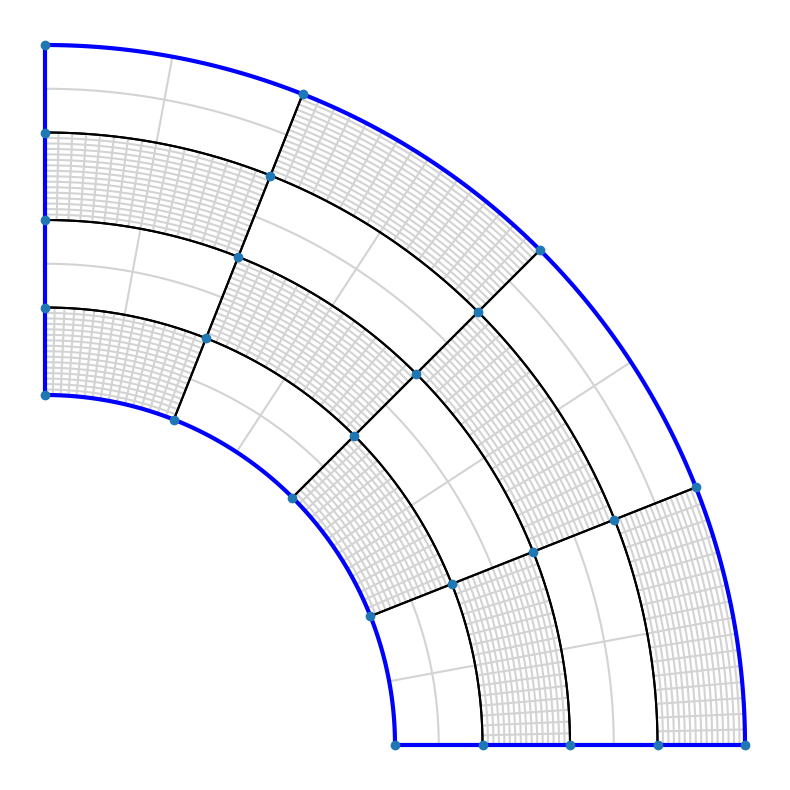

setting up constraints took 0.03246045112609863 seconds.
Basis setup took 0.002602815628051758 seconds
Setting up IETI-mapper took 0.0757 seconds.
Assembling the system took 0.14 seconds.
Computing jump matrices took 0.00114 seconds.
Setting up primal system took 0.00173 seconds.
Setting up primal constraints took 0.0135 seconds.
Computing primal basis took 0.0217 seconds.
Setting up Schur complements took 0.00229 seconds.
Setting up selection scaling took 0.0029 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 4.912 stopped after 11 iterations with relres 3.787e-07 after 0.0426 seconds.
pcg with preconditioned condition number κ ~ 8.516 stopped after 16 iterations with relres 7.439e-07 after 0.0313 seconds.
Computing full solution from skeleton took 0.0033 seconds.
Full time for the IETI-solver: 0.0454 seconds
#####################################################
Iteration 3


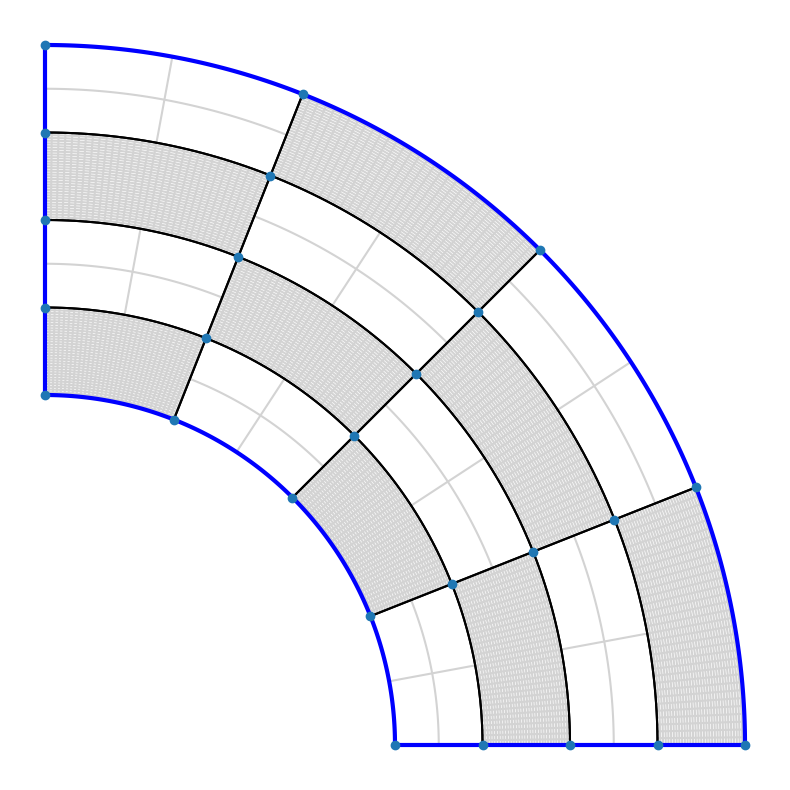

setting up constraints took 0.03747987747192383 seconds.
Basis setup took 0.0029823780059814453 seconds
Setting up IETI-mapper took 0.0807 seconds.
Assembling the system took 0.167 seconds.
Computing jump matrices took 0.00155 seconds.
Setting up primal system took 0.00198 seconds.
Setting up primal constraints took 0.0152 seconds.
Computing primal basis took 0.0327 seconds.
Setting up Schur complements took 0.00343 seconds.
Setting up selection scaling took 0.00315 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 4.993 stopped after 11 iterations with relres 3.833e-07 after 0.0529 seconds.
pcg with preconditioned condition number κ ~ 11.85 stopped after 18 iterations with relres 5.696e-07 after 0.892 seconds.
Computing full solution from skeleton took 0.0621 seconds.
Full time for the IETI-solver: 0.119 seconds
#####################################################


In [43]:
degs = (2,3,4,5,6,7,8)
maxiters=(6,6,6,5,5,4,4) ##<8

degs=(1,)
maxiters=(4,)

R1 = np.zeros((max(maxiters),2*len(degs)))
R2 = np.zeros((max(maxiters),2*len(degs)))

f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1.}
dir_data = {0:0}

plot=True

for i, deg in enumerate(degs):
    N = deg+1
    knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
    M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
    M.h_refine()
    M.h_refine()
    M.set_domain_id({1:{0,1,2,3,6,9,12,15}})
    #M.h_refine({p:-1 for p in {0,1,2,3,6,9,12,15}})
    M.h_refine({p:-1 for p in M.domains[0]})

    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiters[i]):
        print("Iteration {}".format(k))
        if plot:
            M.plotmesh(figsize=(10,10),color={1:'white',0:'white'}, knots=1, bwidth=3, nodes=1, bcolor={0:'blue'})
            plt.axis('off');
            plt.axis('scaled');
            plt.savefig('/home/wolfman/Pictures/IETI-checkerboard/i'+str(k)+'.pdf',bbox_inches='tight')
            plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        t_IETI = 0
        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(a)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=a,f=f)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]

        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=True)
        I = IetiSystem(A, B, RHS, N)

        # A_full = I.SaddlePointSystem(format='csc')
        # RHS_full = I.RHSforSaddlePointSystem()
        # eps=1e-6

        # z = np.zeros(A_full.shape[0])
        # z[-B[0].shape[0]:]=eps
        # A_full += scipy.sparse.spdiags(z,0,*A_full.shape)
    
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        t=time.time()

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        t_IETI+=time.time()-t
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        t_IETI+=time.time()-t
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        t_IETI+=time.time()-t
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        t_IETI+=time.time()-t
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        SD.setupSelectionScaling()
        t_IETI+=time.time()-t
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)

        #t=time.time()
        #U = solvers.make_solver(A_full, symm=True)@RHS_full
        #print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R1[k,2*i] = it
        R1[k,2*i+1] = abs(max_eig/min_eig)

        P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P, output=True, rtol=1e-6, atol=1e-12)
        R2[k,2*i] = it
        R2[k,2*i+1] = abs(max_eig/min_eig)
        
        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        t=time.time()
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        t_IETI+=time.time()-t
        print("Computing full solution from skeleton took {:.3} seconds.".format(time.time()-t))
        print("Full time for the IETI-solver: {:.3} seconds".format(t_IETI))
        #print(len(u))
        #MP.plot(u)

        #err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        #marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        #marked_patches = {p:None for p in marked_patches}

        #M.h_refine(-1);
        M.h_refine({p:-1 for p in {4,5,7,8,10,11,13,14}})
        print("#####################################################")
#np.savetxt('checkerboard_badselection.txt', R1, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')
#np.savetxt('checkerboard_badedge.txt', R2, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')

In [42]:
np.savetxt('checkerboard_disselection.txt', R1, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')
np.savetxt('checkerboard_disedge.txt', R2, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')

In [38]:
M.domains

{0: {4, 5, 7, 8, 10, 11, 13, 14}, 1: {0, 1, 2, 3, 6, 9, 12, 15}}

In [30]:
np.savetxt('checkerboard_badselection.txt', R1, fmt=len(degs)*('%d','%1.1e'), delimiter = ' & ', newline='\\\\\n')

In [28]:
R2

array([[13.     ,  7.77552, 15.     , 11.31575, 17.     , 14.68183, 17.     , 17.6817 , 18.     , 20.42196, 19.     , 22.9373 , 19.     , 25.22698],
       [15.     , 10.77712, 17.     , 15.33805, 18.     , 19.22958, 19.     , 22.71833, 19.     , 25.77105, 21.     , 28.60248, 22.     , 31.15119],
       [17.     , 14.93362, 18.     , 20.165  , 19.     , 24.60286, 20.     , 28.45826, 22.     , 31.87577, 23.     , 34.95857, 23.     , 37.6681 ],
       [18.     , 19.71172, 20.     , 25.63417, 21.     , 30.54072, 23.     , 34.8209 , 25.     , 38.57973, 25.     , 41.82201, 25.     , 44.69519],
       [20.     , 25.12048, 22.     , 31.71316, 23.     , 37.06217, 25.     , 41.67528, 25.     , 45.50178,  0.     ,  0.     ,  0.     ,  0.     ],
       [23.     , 31.15982, 24.     , 38.27546, 25.     , 44.0541 ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ]])

In [30]:
M.outer_boundaries

{0: {(0, 0),
  (0, 2),
  (1, 0),
  (2, 2),
  (4, 0),
  (5, 2),
  (7, 0),
  (7, 3),
  (9, 3),
  (11, 1),
  (11, 2),
  (12, 1),
  (13, 3),
  (14, 1),
  (15, 1),
  (15, 3)}}

In [34]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

setting up constraints took 0.011634349822998047 seconds.
Basis setup took 0.0031998157501220703 seconds
deg = 3
0


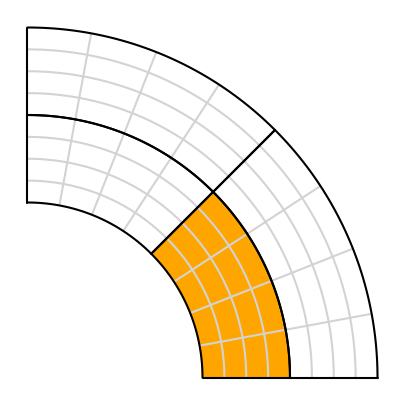

setting up constraints took 0.0060384273529052734 seconds.
Basis setup took 0.0019192695617675781 seconds
Setting up IETI-mapper took 0.0209 seconds.
Assembling the system took 0.0469 seconds.
Computing jump matrices took 0.000532 seconds.
Setting up primal system took 0.00266 seconds.
Setting up primal constraints took 0.00403 seconds.
Computing primal basis took 0.00617 seconds.
Setting up Schur complements took 0.00241 seconds.
Setting up selection scaling took 0.00243 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 3.678 stopped after 7 iterations with relres 3.616e-08 after 0.00629 seconds.
Residual contributions took 0.0324 seconds.
Jump contributions took 0.0258 seconds.
Estimating and marking took 0.0583 seconds.
setting up constraints took 0.02698969841003418 seconds.
Basis setup took 0.002353191375732422 seconds
Patch-splitting took 0.039 seconds for 3 patches
setting up constraints took 0.031195878982543945 seconds.
Basis setup took 0.0022842

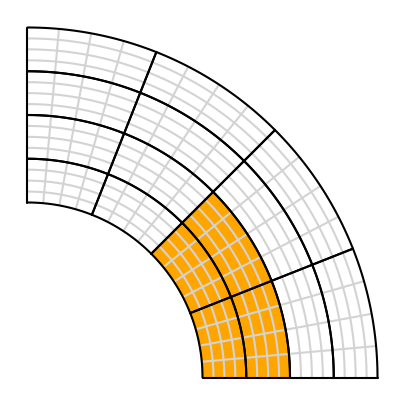

setting up constraints took 0.034909725189208984 seconds.
Basis setup took 0.0026514530181884766 seconds
Setting up IETI-mapper took 0.0756 seconds.
Assembling the system took 0.181 seconds.
Computing jump matrices took 0.00123 seconds.
Setting up primal system took 0.00261 seconds.
Setting up primal constraints took 0.014 seconds.
Computing primal basis took 0.0247 seconds.
Setting up Schur complements took 0.00169 seconds.
Setting up selection scaling took 0.00791 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 9.435 stopped after 16 iterations with relres 8.478e-07 after 0.0452 seconds.
Residual contributions took 0.116 seconds.
Jump contributions took 0.155 seconds.
Estimating and marking took 0.272 seconds.
setting up constraints took 0.06221914291381836 seconds.
Basis setup took 0.0029790401458740234 seconds
Patch-splitting took 0.0781 seconds for 3 patches
setting up constraints took 0.06798124313354492 seconds.
Basis setup took 0.002436399459838

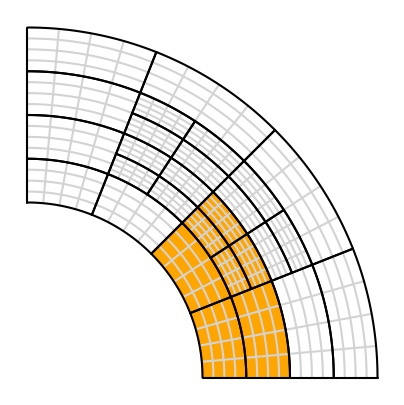

setting up constraints took 0.07046175003051758 seconds.
Basis setup took 0.002658367156982422 seconds
Setting up IETI-mapper took 0.138 seconds.
Assembling the system took 0.255 seconds.
Computing jump matrices took 0.00172 seconds.
Setting up primal system took 0.00316 seconds.
Setting up primal constraints took 0.0241 seconds.
Computing primal basis took 0.0443 seconds.
Setting up Schur complements took 0.00308 seconds.
Setting up selection scaling took 0.014 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 10.55 stopped after 20 iterations with relres 6.118e-07 after 0.0971 seconds.
Residual contributions took 0.208 seconds.
Jump contributions took 0.332 seconds.
Estimating and marking took 0.54 seconds.
setting up constraints took 0.0963752269744873 seconds.
Basis setup took 0.002914905548095703 seconds
Patch-splitting took 0.113 seconds for 3 patches
setting up constraints took 0.10457491874694824 seconds.
Basis setup took 0.0032532215118408203 sec

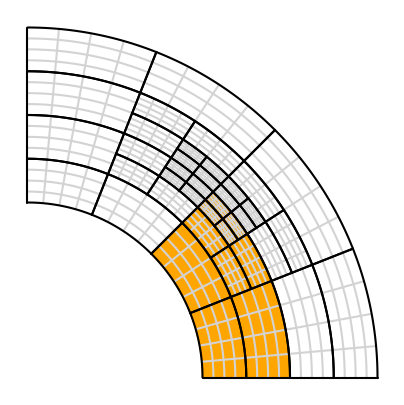

setting up constraints took 0.1052541732788086 seconds.
Basis setup took 0.0034873485565185547 seconds
Setting up IETI-mapper took 0.184 seconds.
Assembling the system took 0.352 seconds.
Computing jump matrices took 0.00244 seconds.
Setting up primal system took 0.00337 seconds.
Setting up primal constraints took 0.0337 seconds.
Computing primal basis took 0.0644 seconds.
Setting up Schur complements took 0.0047 seconds.
Setting up selection scaling took 0.02 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.3 stopped after 21 iterations with relres 5.48e-07 after 0.173 seconds.
Residual contributions took 0.303 seconds.
Jump contributions took 0.519 seconds.
Estimating and marking took 0.822 seconds.
setting up constraints took 0.13243532180786133 seconds.
Basis setup took 0.0031173229217529297 seconds
Patch-splitting took 0.152 seconds for 3 patches
setting up constraints took 0.14180517196655273 seconds.
Basis setup took 0.0034220218658447266 secon

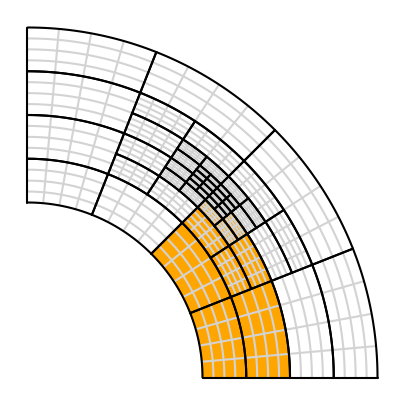

setting up constraints took 0.14336657524108887 seconds.
Basis setup took 0.003902912139892578 seconds
Setting up IETI-mapper took 0.247 seconds.
Assembling the system took 0.463 seconds.
Computing jump matrices took 0.00289 seconds.
Setting up primal system took 0.00373 seconds.
Setting up primal constraints took 0.068 seconds.
Computing primal basis took 0.0955 seconds.
Setting up Schur complements took 0.00642 seconds.
Setting up selection scaling took 0.0271 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.46 stopped after 21 iterations with relres 9.593e-07 after 0.2 seconds.
Residual contributions took 0.402 seconds.
Jump contributions took 0.694 seconds.
Estimating and marking took 1.1 seconds.
setting up constraints took 0.1760263442993164 seconds.
Basis setup took 0.0034284591674804688 seconds
Patch-splitting took 0.203 seconds for 4 patches
setting up constraints took 0.1777477264404297 seconds.
Basis setup took 0.0034112930297851562 seconds

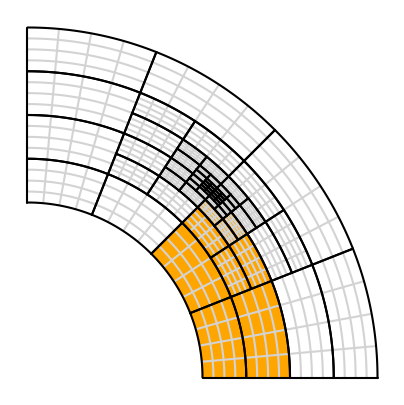

setting up constraints took 0.17704319953918457 seconds.
Basis setup took 0.003777027130126953 seconds
Setting up IETI-mapper took 0.296 seconds.
Assembling the system took 0.553 seconds.
Computing jump matrices took 0.0034 seconds.
Setting up primal system took 0.00363 seconds.
Setting up primal constraints took 0.0539 seconds.
Computing primal basis took 0.108 seconds.
Setting up Schur complements took 0.00742 seconds.
Setting up selection scaling took 0.0331 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.54 stopped after 22 iterations with relres 5.114e-07 after 0.244 seconds.
Residual contributions took 0.49 seconds.
Jump contributions took 0.872 seconds.
Estimating and marking took 1.36 seconds.
setting up constraints took 0.23802876472473145 seconds.
Basis setup took 0.004082202911376953 seconds
Patch-splitting took 0.285 seconds for 7 patches
setting up constraints took 0.24328088760375977 seconds.
Basis setup took 0.004305124282836914 second

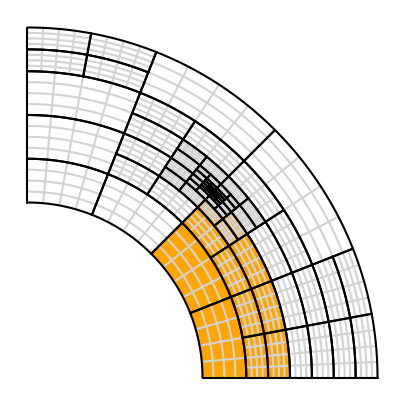

setting up constraints took 0.24253630638122559 seconds.
Basis setup took 0.004214048385620117 seconds
Setting up IETI-mapper took 0.404 seconds.
Assembling the system took 0.747 seconds.
Computing jump matrices took 0.0047 seconds.
Setting up primal system took 0.00415 seconds.
Setting up primal constraints took 0.0791 seconds.
Computing primal basis took 0.151 seconds.
Setting up Schur complements took 0.00964 seconds.
Setting up selection scaling took 0.047 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.47 stopped after 22 iterations with relres 8.458e-07 after 0.35 seconds.
Residual contributions took 0.69 seconds.
Jump contributions took 1.19 seconds.
Estimating and marking took 1.88 seconds.
setting up constraints took 0.2926464080810547 seconds.
Basis setup took 0.0043354034423828125 seconds
Patch-splitting took 0.34 seconds for 6 patches
setting up constraints took 0.2920553684234619 seconds.
Basis setup took 0.004323482513427734 seconds
###

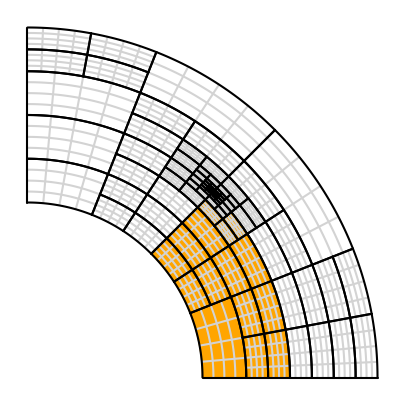

setting up constraints took 0.28846287727355957 seconds.
Basis setup took 0.004427194595336914 seconds
Setting up IETI-mapper took 0.487 seconds.
Assembling the system took 0.885 seconds.
Computing jump matrices took 0.00628 seconds.
Setting up primal system took 0.00428 seconds.
Setting up primal constraints took 0.0932 seconds.
Computing primal basis took 0.187 seconds.
Setting up Schur complements took 0.0121 seconds.
Setting up selection scaling took 0.0555 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.43 stopped after 22 iterations with relres 8.606e-07 after 0.444 seconds.
Residual contributions took 0.81 seconds.
Jump contributions took 1.43 seconds.
Estimating and marking took 2.24 seconds.
setting up constraints took 0.33938097953796387 seconds.
Basis setup took 0.004785776138305664 seconds
Patch-splitting took 0.392 seconds for 6 patches
setting up constraints took 0.34031224250793457 seconds.
Basis setup took 0.004708528518676758 seconds

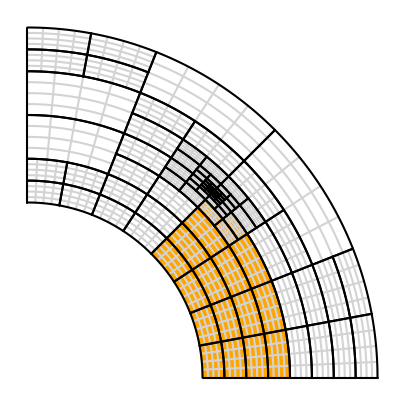

setting up constraints took 0.33829283714294434 seconds.
Basis setup took 0.0048067569732666016 seconds
Setting up IETI-mapper took 0.568 seconds.
Assembling the system took 1.05 seconds.
Computing jump matrices took 0.00721 seconds.
Setting up primal system took 0.0045 seconds.
Setting up primal constraints took 0.107 seconds.
Computing primal basis took 0.229 seconds.
Setting up Schur complements took 0.0147 seconds.
Setting up selection scaling took 0.0653 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.41 stopped after 22 iterations with relres 9.468e-07 after 0.526 seconds.
Residual contributions took 0.93 seconds.
Jump contributions took 1.65 seconds.
Estimating and marking took 2.58 seconds.
setting up constraints took 0.40761303901672363 seconds.
Basis setup took 0.0051059722900390625 seconds
Patch-splitting took 0.482 seconds for 8 patches
setting up constraints took 0.4089326858520508 seconds.
Basis setup took 0.005195140838623047 seconds
#

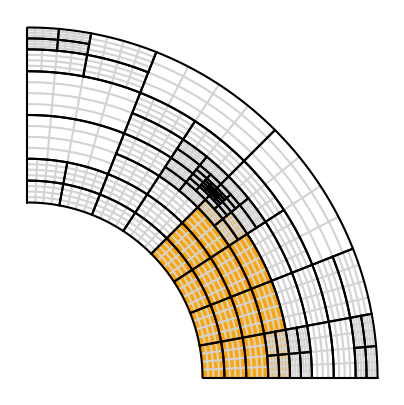

setting up constraints took 0.40571141242980957 seconds.
Basis setup took 0.0052890777587890625 seconds
Setting up IETI-mapper took 0.679 seconds.
Assembling the system took 1.26 seconds.
Computing jump matrices took 0.00927 seconds.
Setting up primal system took 0.00517 seconds.
Setting up primal constraints took 0.126 seconds.
Computing primal basis took 0.283 seconds.
Setting up Schur complements took 0.0175 seconds.
Setting up selection scaling took 0.0808 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.42 stopped after 22 iterations with relres 9.675e-07 after 0.655 seconds.
Residual contributions took 1.12 seconds.
Jump contributions took 2.0 seconds.
Estimating and marking took 3.12 seconds.
setting up constraints took 0.4930908679962158 seconds.
Basis setup took 0.005587577819824219 seconds
Patch-splitting took 0.576 seconds for 8 patches
setting up constraints took 0.48033881187438965 seconds.
Basis setup took 0.006272315979003906 seconds
##

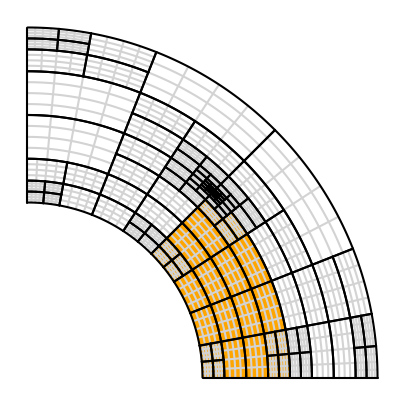

setting up constraints took 0.4760863780975342 seconds.
Basis setup took 0.005279541015625 seconds
Setting up IETI-mapper took 0.786 seconds.
Assembling the system took 1.44 seconds.
Computing jump matrices took 0.0107 seconds.
Setting up primal system took 0.00514 seconds.
Setting up primal constraints took 0.146 seconds.
Computing primal basis took 0.347 seconds.
Setting up Schur complements took 0.0204 seconds.
Setting up selection scaling took 0.0958 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.54 stopped after 23 iterations with relres 5.384e-07 after 0.797 seconds.
Residual contributions took 1.32 seconds.
Jump contributions took 2.34 seconds.
Estimating and marking took 3.65 seconds.
setting up constraints took 0.5740766525268555 seconds.
Basis setup took 0.005995273590087891 seconds
Patch-splitting took 0.706 seconds for 12 patches
setting up constraints took 0.5805990695953369 seconds.
Basis setup took 0.006213188171386719 seconds
#######

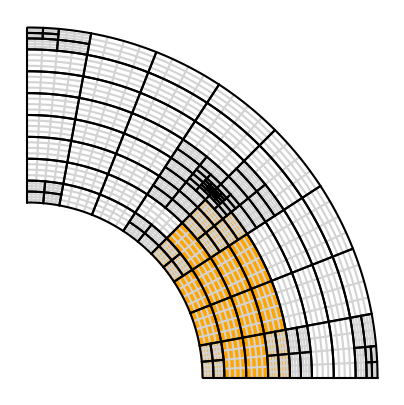

setting up constraints took 0.5762896537780762 seconds.
Basis setup took 0.005841255187988281 seconds
Setting up IETI-mapper took 0.956 seconds.
Assembling the system took 1.78 seconds.
Computing jump matrices took 0.0138 seconds.
Setting up primal system took 0.00559 seconds.
Setting up primal constraints took 0.181 seconds.
Computing primal basis took 0.46 seconds.
Setting up Schur complements took 0.0485 seconds.
Setting up selection scaling took 0.13 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.71 stopped after 23 iterations with relres 5.465e-07 after 1.37 seconds.
Residual contributions took 1.62 seconds.
Jump contributions took 2.84 seconds.
Estimating and marking took 4.46 seconds.
setting up constraints took 0.6788270473480225 seconds.
Basis setup took 0.006502389907836914 seconds
Patch-splitting took 0.851 seconds for 12 patches
setting up constraints took 0.6853423118591309 seconds.
Basis setup took 0.00668025016784668 seconds
#########

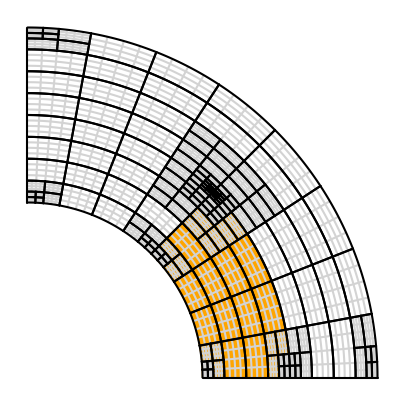

setting up constraints took 0.6847994327545166 seconds.
Basis setup took 0.0066683292388916016 seconds
Setting up IETI-mapper took 1.13 seconds.
Assembling the system took 2.15 seconds.
Computing jump matrices took 0.0173 seconds.
Setting up primal system took 0.00609 seconds.
Setting up primal constraints took 0.218 seconds.
Computing primal basis took 0.712 seconds.
Setting up Schur complements took 0.0496 seconds.
Setting up selection scaling took 0.157 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.86 stopped after 23 iterations with relres 6.149e-07 after 1.72 seconds.
Residual contributions took 1.91 seconds.
Jump contributions took 3.36 seconds.
Estimating and marking took 5.28 seconds.
setting up constraints took 0.8101165294647217 seconds.
Basis setup took 0.0073969364166259766 seconds
Patch-splitting took 1.02 seconds for 15 patches
setting up constraints took 0.8150522708892822 seconds.
Basis setup took 0.00730443000793457 seconds
#######

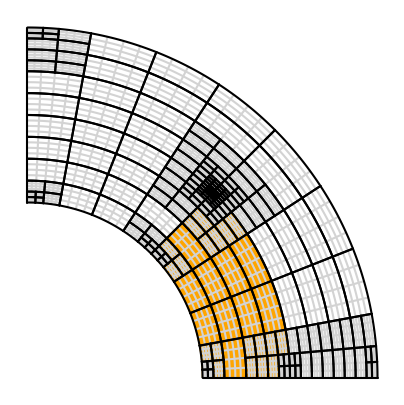

setting up constraints took 0.8123087882995605 seconds.
Basis setup took 0.007274627685546875 seconds
Setting up IETI-mapper took 1.35 seconds.
Assembling the system took 2.52 seconds.
Computing jump matrices took 0.0224 seconds.
Setting up primal system took 0.00664 seconds.
Setting up primal constraints took 0.262 seconds.
Computing primal basis took 1.2 seconds.
Setting up Schur complements took 0.0531 seconds.
Setting up selection scaling took 0.187 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.61 stopped after 22 iterations with relres 9.808e-07 after 1.89 seconds.
Residual contributions took 2.26 seconds.
Jump contributions took 4.0 seconds.
Estimating and marking took 6.26 seconds.
setting up constraints took 1.0114843845367432 seconds.
Basis setup took 0.008549213409423828 seconds
Patch-splitting took 1.39 seconds for 23 patches
setting up constraints took 1.0378077030181885 seconds.
Basis setup took 0.008541345596313477 seconds
###########

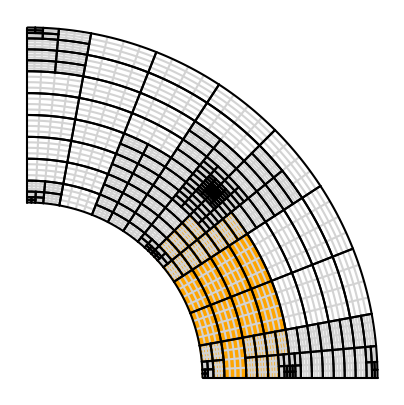

setting up constraints took 1.0283763408660889 seconds.
Basis setup took 0.008501529693603516 seconds
Setting up IETI-mapper took 1.71 seconds.
Assembling the system took 3.18 seconds.
Computing jump matrices took 0.0317 seconds.
Setting up primal system took 0.00753 seconds.
Setting up primal constraints took 0.329 seconds.
Computing primal basis took 2.22 seconds.
Setting up Schur complements took 0.0759 seconds.
Setting up selection scaling took 0.238 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 12.2 stopped after 23 iterations with relres 6.373e-07 after 2.42 seconds.
Residual contributions took 2.84 seconds.
Jump contributions took 5.07 seconds.
Estimating and marking took 7.91 seconds.


/home/wolfman/miniforge3/lib/python3.12/site-packages/pyiga/bspline.py:833: MatrixRankWarning: Matrix is exactly singular
  P = scipy.sparse.linalg.spsolve(C2,C1)


298 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.5    , 0.50001, 0.50002, 0.50002, 0.50003, 0.50003, 0.50003, 0.50003]), 3),) 376 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.5    , 0.50002, 0.50002, 0.50002, 0.50002]), 3),)
interface coupling not possible
299 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.5    , 0.50001, 0.50002, 0.50002, 0.50003, 0.50003, 0.50003, 0.50003]), 3),) 377 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.5    , 0.50002, 0.50002, 0.50002, 0.50002]), 3),)
interface coupling not possible
307 (KnotVector(array([0.49997, 0.49997, 0.49997, 0.49997, 0.49998, 0.49998, 0.49999, 0.5    , 0.5    , 0.5    , 0.5    ]), 3),) 309 (KnotVector(array([0.49997, 0.49997, 0.49997, 0.49997, 0.49998, 0.49998, 0.49998, 0.49998]), 3),)
interface coupling not possible
312 (KnotVector(array([0.49997, 0.49997, 0.49997, 0.49997, 0.49998, 0.49998, 0.49999, 0.5    , 0.5    , 0.5    , 0.5    ]), 3),) 400 (KnotVector(array([0.49997, 0.49997, 0.49997, 0.49997, 0.49998, 0.49998, 0.499

AssertionError: Not an H^1-conforming function space.

In [49]:
f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1000.}
dir_data = {0:0}

plot=True

degs = (3,)
maxiter=15
R = np.zeros((maxiter,3*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Heat_annulus(deg,N)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        n_p = MP.numpatches
        if plot:
            M.draw(figsize=(5,5),color={1:'orange',0:'white'}, knots=1, bwidth=0.01, nodes=0)
            plt.axis('off');
            plt.axis('scaled');
            #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
            plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(a)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=a,f=f)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)

        t=time.time()
        SD.setupSelectionScaling(a=a)
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        #A_full = I.SaddlePointSystem(format='csc')
        #RHS_full = I.RHSforSaddlePointSystem()

        # t=time.time()
        # U = solvers.make_solver(A_full)@RHS_full
        # print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R[k,3*i] = n_p
        R[k,3*i+1] = abs(max_eig/min_eig)
        R[k,3*i+2] = it 

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #MP.plot(u)

        t=time.time()
        err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        marked_patches = adaptive.quick_mark(err_ind, theta=0.9)
        marked_patches = {p:None for p in marked_patches}
        print("Estimating and marking took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)
        print("Patch-splitting took {:.3} seconds for {} patches".format(time.time()-t, len(marked_patches)))

        marked_patches = consistency_split(MP,a)
        #print(marked_patches)
        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)

        print("#####################################################")

#np.savetxt('singular_selection_consistency', R, fmt=len(degs)*('%d', '%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')

In [44]:
def Inductor(deg,N, airgap=0.025):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,airgap)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,airgap)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,airgap)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.25+airgap)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.25+airgap)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.25+airgap)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.75+airgap)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.75+airgap)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.75+airgap)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.0+airgap)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.0+airgap)),
        geometry.unit_square().scale(0.5).translate((1.5,1.0+airgap)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [45]:
mu0 = 4*np.pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
#nu = {'C1': 1., 'C2':1., 'Fe':1., 'Air': 1.}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}
dir_data = {0:0}

setting up constraints took 0.08768391609191895 seconds.
Basis setup took 0.0030732154846191406 seconds
deg = 2
0


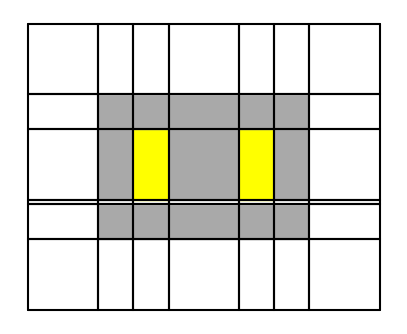

setting up constraints took 0.09052467346191406 seconds.
Basis setup took 0.0030167102813720703 seconds
Setting up IETI-mapper took 0.177 seconds.
Assembling the system took 0.306 seconds.
Computing jump matrices took 0.00239 seconds.
Setting up primal system took 0.00366 seconds.
Setting up primal constraints took 0.0368 seconds.
Computing primal basis took 0.0539 seconds.
Setting up Schur complements took 0.0178 seconds.
Setting up selection scaling took 0.00843 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 42.36 stopped after 18 iterations with relres 9.656e-07 after 0.126 seconds.
Residual contributions took 0.233 seconds.
Jump contributions took 0.354 seconds.
Estimating and marking took 0.587 seconds.
setting up constraints took 0.20621395111083984 seconds.
Basis setup took 0.0036792755126953125 seconds
Patch-splitting took 0.281 seconds for 14 patches
{9: None, 26: None, 22: None, 11: None, 8: None, 32: None, 30: None, 12: None, 10: None}
setti

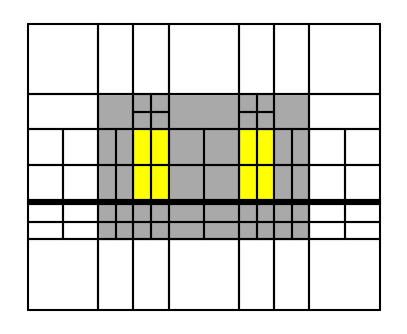

setting up constraints took 0.27463650703430176 seconds.
Basis setup took 0.004197120666503906 seconds
Setting up IETI-mapper took 0.479 seconds.
Assembling the system took 0.768 seconds.
Computing jump matrices took 0.00552 seconds.
Setting up primal system took 0.00349 seconds.
Setting up primal constraints took 0.0895 seconds.
Computing primal basis took 0.153 seconds.
Setting up Schur complements took 0.011 seconds.
Setting up selection scaling took 0.0208 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 65.94 stopped after 39 iterations with relres 6.673e-07 after 0.713 seconds.
Residual contributions took 0.65 seconds.
Jump contributions took 1.26 seconds.
Estimating and marking took 1.91 seconds.
setting up constraints took 0.5369279384613037 seconds.
Basis setup took 0.005164623260498047 seconds
Patch-splitting took 0.8 seconds for 31 patches
{26: None, 109: None, 22: None, 90: None, 110: None}
setting up constraints took 0.5726242065429688 secon

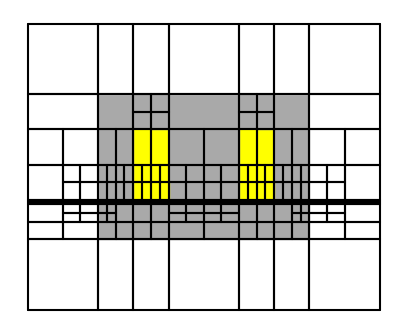

setting up constraints took 0.567979097366333 seconds.
Basis setup took 0.0047762393951416016 seconds
Setting up IETI-mapper took 0.953 seconds.
Assembling the system took 1.52 seconds.
Computing jump matrices took 0.0115 seconds.
Setting up primal system took 0.0059 seconds.
Setting up primal constraints took 0.181 seconds.
Computing primal basis took 0.355 seconds.
Setting up Schur complements took 0.0217 seconds.
Setting up selection scaling took 0.0406 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 93.1 stopped after 50 iterations with relres 9.393e-07 after 1.97 seconds.
Residual contributions took 1.26 seconds.
Jump contributions took 2.67 seconds.
Estimating and marking took 3.94 seconds.
setting up constraints took 0.9245617389678955 seconds.
Basis setup took 0.0063822269439697266 seconds
Patch-splitting took 1.46 seconds for 42 patches
{85: None, 86: None, 94: None, 95: None}
setting up constraints took 0.9563615322113037 seconds.
Basis setup 

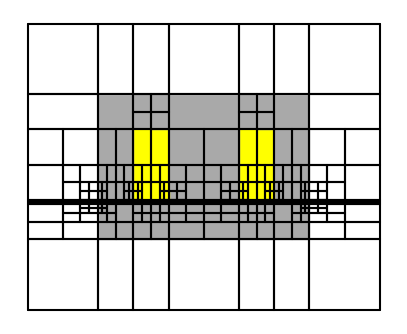

setting up constraints took 0.9563908576965332 seconds.
Basis setup took 0.006261348724365234 seconds
Setting up IETI-mapper took 1.55 seconds.
Assembling the system took 2.43 seconds.
Computing jump matrices took 0.0216 seconds.
Setting up primal system took 0.013 seconds.
Setting up primal constraints took 0.295 seconds.
Computing primal basis took 1.12 seconds.
Setting up Schur complements took 0.0677 seconds.
Setting up selection scaling took 0.0814 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 99.89 stopped after 59 iterations with relres 7.276e-07 after 5.19 seconds.
Residual contributions took 1.93 seconds.
Jump contributions took 4.53 seconds.
Estimating and marking took 6.46 seconds.
setting up constraints took 1.4086334705352783 seconds.
Basis setup took 0.008414268493652344 seconds
Patch-splitting took 2.39 seconds for 53 patches
{8: None, 106: None, 105: None}
setting up constraints took 1.4340357780456543 seconds.
Basis setup took 0.00823

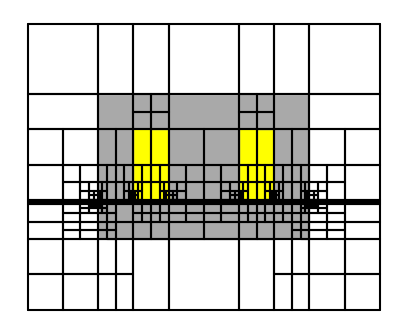

setting up constraints took 1.4164800643920898 seconds.
Basis setup took 0.008347511291503906 seconds
Setting up IETI-mapper took 2.3 seconds.
Assembling the system took 3.59 seconds.
Computing jump matrices took 0.0389 seconds.
Setting up primal system took 0.0256 seconds.
Setting up primal constraints took 0.433 seconds.
Computing primal basis took 3.4 seconds.
Setting up Schur complements took 0.115 seconds.
Setting up selection scaling took 0.118 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 110.7 stopped after 68 iterations with relres 8.973e-07 after 8.66 seconds.


IndexError: index 4 is out of bounds for axis 0 with size 4

In [48]:
degs = (2,)
maxiters=1*(10,)
R = np.zeros((maxiter,2*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Inductor(deg,N, airgap=0.03)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiters[i]):
        print(k)
        n_p = MP.numpatches
        M.plotmesh(figsize=(5,5),color={'C1':'yellow', 'C2':'yellow', 'Fe':'darkgrey', 'Air':'white'}, knots=0, bwidth=0.01, patch_idx=0)
        plt.axis('off');
        plt.axis('scaled');
        #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(nu)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=nu,f=j)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)

        t=time.time()
        SD.setupSelectionScaling()
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        #A_full = I.SaddlePointSystem(format='csc')
        #RHS_full = I.RHSforSaddlePointSystem()

        # t=time.time()
        # U = solvers.make_solver(A_full)@RHS_full
        # print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=2000, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        #R[k,3*i] = n_p
        R[k,2*i+1] = abs(max_eig/min_eig)
        R[k,2*i] = it 

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #MP.plot(u)

        t=time.time()
        err_ind=adaptive.mp_resPois(MP,u,a=nu, f=j, M=MaT)

        marked_patches = adaptive.quick_mark(err_ind, theta=0.95)
        marked_patches = {p:None for p in marked_patches}
        print("Estimating and marking took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)
        print("Patch-splitting took {:.3} seconds for {} patches".format(time.time()-t, len(marked_patches)))

        marked_patches = {0}
        while len(marked_patches)>0:
            marked_patches = consistency_split(MP,nu)
            print(marked_patches)
            M.h_refine(patches=marked_patches,ref="rs");
            MP = assemble.Multipatch(M, automatch=True)

        print("#####################################################")

In [143]:
M = Inductor(deg,N, airgap=0.2)
#MP = assemble.Multipatch(M, automatch=True)

In [144]:
M.h_refine({10:None, 17:None, 24:None})

{10: (10, 42, 43, 44), 17: (17, 45, 46, 47), 24: (24, 48, 49, 50)}

In [147]:
IMap = IetiMapper(M, dir_data)
IMap.parametersort(nu)
A, RHS = IMap.assemble(a=nu,f=j)
N = [A.shape[0] for A in A]
B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
SD = ScaledDirichletPreconditioner(A, B, IMap)
SD.setupSelectionScaling()

In [148]:
SD.setupSelectionScaling()

In [151]:
print(M.patch_domains)

{0: 'Air', 1: 'Air', 2: 'Air', 3: 'Air', 4: 'Air', 5: 'Air', 6: 'Air', 7: 'Air', 8: 'Fe', 9: 'Fe', 10: 'Fe', 11: 'Fe', 12: 'Fe', 13: 'Air', 14: 'Air', 15: 'Air', 16: 'Air', 17: 'Air', 18: 'Air', 19: 'Air', 20: 'Air', 21: 'Air', 22: 'Fe', 23: 'C1', 24: 'Fe', 25: 'C2', 26: 'Fe', 27: 'Air', 28: 'Air', 29: 'Fe', 30: 'Fe', 31: 'Fe', 32: 'Fe', 33: 'Fe', 34: 'Air', 35: 'Air', 36: 'Air', 37: 'Air', 38: 'Air', 39: 'Air', 40: 'Air', 41: 'Air', 42: 'Fe', 43: 'Fe', 44: 'Fe', 45: 'Air', 46: 'Air', 47: 'Air', 48: 'Fe', 49: 'Fe', 50: 'Fe'}


In [152]:
SD.D[8]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 27 stored elements and shape (40, 40)>

In [16]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

In [25]:
f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1e4}
dir_data = {0:0}

In [79]:
degs = (2,3,5,8)
maxiter=10
R = np.zeros((maxiter,4*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Heat_annulus(deg,N)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        #n_p = MP.numpatches
        # M.draw(figsize=(5,5),color={1:'yellow',0:'white'}, knots=1, bwidth=0.01, patch_idx=1)
        # plt.axis('off');
        # plt.axis('scaled');
        # #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        # plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        IMap = IetiMapper(M, dir_data)
        A, RHS = IMap.assemble(a=a,f=f)
        N = [A.shape[0] for A in A]
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)

        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        primal = PrimalSystem(IMap.nodes_as_primals())
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        F, b = I.SchurComplement(), I.RHSforSchurComplement()

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)
        
        #SD.setupSelectionScaling(a=a)
        P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P, output=True, rtol=1e-6, atol=1e-12)

        R[k,4*i]  = MP.numpatches
        R[k,4*i+1] = MP.N_ofs[-1]
        R[k,4*i+2]= abs(max_eig/min_eig)
        R[k,4*i+3]= it

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #print(len(u))
        #MP.plot(u)

        err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        marked_patches = {p:None for p in marked_patches}

        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)
        
        # marked_patches = consistency_split(MP)
        # M.h_refine(patches=marked_patches,ref="rs");
        # MP = assemble.Multipatch(M, automatch=True)
        
        print("#####################################################")
np.savetxt('IETI_adaptive_edge.txt', R, fmt=len(degs)*('%d','%1.2e', '%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')
#np.savetxt('IETI_adaptive_selection.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')
#np.savetxt('IETI_adaptive_selection_consistency.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')

setting up constraints took 0.012381315231323242 seconds.
Basis setup took 0.0037136077880859375 seconds
deg = 2
0
setting up constraints took 0.011928558349609375 seconds.
Basis setup took 0.003948211669921875 seconds
pcg with preconditioned condition number κ ~ 2.393472823904742 stopped after 7 iterations with relres 2.2787361828775655e-08 after 0.0022644996643066406 seconds.
Residual contributions took 0.03435945510864258 seconds.
Jump contributions took 0.03076338768005371 seconds.
setting up constraints took 0.03662848472595215 seconds.
Basis setup took 0.00255584716796875 seconds
#####################################################
1
setting up constraints took 0.036339759826660156 seconds.
Basis setup took 0.0022606849670410156 seconds
pcg with preconditioned condition number κ ~ 6.05042980376718 stopped after 14 iterations with relres 3.799900997402126e-07 after 0.019454002380371094 seconds.
Residual contributions took 0.14502882957458496 seconds.
Jump contributions took 0.171